In [3]:
%pip install nltk

In [4]:
%pip install gtts

In [5]:
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [6]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [10]:
with open('pharmacy.json') as content:
    data1 = json.load(content)

tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', "!", ".", "@", "#"]

for intent in data1['intens']:
    responses[intent['tag']] = intent['responses']
    for lines in intent['patterns']:
        inputs.append(lines)
        tags.append(intent['tag'])

        for pattern in intent['patterns']:
            w = nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w, intent['tag']))

            if intent['tag'] not in classes:
                classes.append(intent['tag'])

data = pd.DataFrame(({"patterns": inputs, "tags": tags}))

In [11]:
data

,patterns,tags
0,Hallo,greeting
1,hallo,greeting
2,Halo,greeting
3,halo,greeting
4,hi,greeting
...,...,...
195,See You,goodbye
196,Sampai Jumpa,goodbye
197,sampai jumpa,goodbye
198,Good Bye,goodbye


In [12]:
data.head()

,patterns,tags
0,Hallo,greeting
1,hallo,greeting
2,Halo,greeting
3,halo,greeting
4,hi,greeting


In [13]:
data.tail()

,patterns,tags
195,See You,goodbye
196,Sampai Jumpa,goodbye
197,sampai jumpa,goodbye
198,Good Bye,goodbye
199,See ya,goodbye


In [14]:
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [15]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

238 unique lemmatized words [',', 'ada', 'agak', 'air', 'allright', 'apa', 'area', 'atau', 'badan', 'badanku', 'bagian', 'bai', 'baik-baik', 'bangun', 'banyak', 'bat', 'batuk', 'batuk-batuk', 'beberapa', 'belakang', 'bengkak', 'benjolan', 'berair', 'beraktivitas', 'berat', 'berbau', 'berdenyut', 'berdetak', 'berdiri', 'beres', 'berkonsentrasi', 'berlangsung', 'berlebihan', 'bernapas', 'berolahraga', 'bersendawa', 'bersin-bersin', 'bertenaga', 'berubah', 'berulang', 'besar', 'biasanya', 'biobot', 'buang', 'butuh', 'bye', 'byee', 'cepat', 'claim', 'dada', 'dan', 'darahku', 'dari', 'demam', 'demamku', 'demmam', 'dengan', 'denyut', 'di', 'diare', 'drastis', 'frekuensi', 'gatal', 'gatal-gatal', 'gejala', 'good', 'hallo', 'halo', 'hangat', 'hari', 'harus', 'haus', 'hebat', 'hi', 'hidung', 'hii', 'hiii', 'ingin', 'ini', 'itu', 'jantung', 'jelas', 'jumpa', 'k', 'kali', 'kamar', 'kamu', 'karena', 'kasih', 'ke', 'kecil', 'keluar', 'keluhan', 'kembung', 'kemerahan', 'kenaikan', 'kepala', 'kering'

In [16]:
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

25 classes ['Biobot', 'alergi', 'anemia', 'asma', 'demam', 'diabetes', 'flu', 'gastroenteritis', 'goodbye', 'greeting', 'hipertensi', 'infeksi-kulit', 'infeksi-saluran-napas', 'infeksi-urinaria', 'jawaban_layanan_klaim', 'jawaban_layanan_obat', 'kolesterol-tinggi', 'maag', 'oke', 'osteoporosis', 'pilek', 'radang-usus', 'sakit-kepala', 'tekanan-darah-rendah', 'thnakyou']


In [17]:
print(len(documents), "documents")

2102 documents


In [18]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[68],
 [68],
 [69],
 [69],
 [70],
 [70],
 [71],
 [72],
 [71],
 [72],
 [14],
 [14],
 [14],
 [14],
 [14],
 [138],
 [48],
 [48],
 [48],
 [139],
 [36, 73, 37],
 [37, 73, 36],
 [36, 140, 37],
 [36, 74],
 [141, 142, 37],
 [19],
 [19],
 [19],
 [19],
 [19],
 [19],
 [75],
 [75],
 [1, 2, 38],
 [15, 16, 1, 39],
 [20, 4, 29],
 [15, 16, 1, 143, 39, 76],
 [20, 4, 77, 29],
 [78, 79],
 [38, 76],
 [1, 2, 78],
 [15, 20, 1, 80],
 [16, 1, 4, 144],
 [21, 145, 15, 16],
 [20, 4, 146, 29, 147, 148],
 [15, 1, 149],
 [15, 150, 80],
 [16, 4, 77, 29],
 [2, 38, 81, 30],
 [1, 151, 38],
 [152, 7, 49, 82],
 [15, 83, 39],
 [83, 4, 153, 31, 154, 29],
 [155],
 [1, 50],
 [84, 85, 49, 40],
 [51, 4, 5],
 [1, 52, 53],
 [17, 1, 4, 41],
 [156, 157, 49, 40],
 [1, 2, 10, 3, 158],
 [54, 1, 55],
 [84, 159, 160, 86, 30],
 [1, 11, 2, 12, 161],
 [5, 12, 42, 56],
 [11, 162],
 [163, 4, 85, 31],
 [42, 56, 1, 2, 87, 3, 7, 31],
 [1, 2, 88, 42, 56],
 [8, 1, 164, 3, 22],
 [43, 17],
 [89, 1, 90, 3, 22],
 [89, 1, 22, 3, 90],
 [1, 91, 165],


In [19]:
x_train = pad_sequences(train)
x_train

array([[  0,   0,   0, ...,   0,   0,  68],
       [  0,   0,   0, ...,   0,   0,  68],
       [  0,   0,   0, ...,   0,   0,  69],
       ...,
       [  0,   0,   0, ...,   0, 136, 137],
       [  0,   0,   0, ...,   0, 236,  67],
       [  0,   0,   0, ...,   0, 135, 237]], dtype=int32)

In [20]:
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  0  0  0  0
  0 15 15 15 15 15 15 15 15  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  6  6  6  6  6  6  6  6  6 17 17 17 17 17 17  1  1  1
  1  1  1  1 22 22 22 22 22 22 10 10 10 10 10 10 10  5  5  5  5  5  5 13
 13 13 13 13 13  3  3  3  3  3  3 21 21 21 21 21 21 16 16 16 16 16 16 20
 20 20 20 20 20 23 23 23 23 23 23  7  7  7  7  7  7 12 12 12 12 12 12 11
 11 11 11 11 11 19 19 19 19 19 19  2  2  2  2  2  2 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 24 24 24 24 18 18 18 18 18 18 18  8  8
  8  8  8  8  8  8  8  8]


In [21]:
input_shape = x_train.shape[1]
print(input_shape)

9


In [22]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  237
output length:  25


In [23]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [24]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

In [25]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10, return_sequences=True, recurrent_dropout=0.2)(x) # Layer Long Short Term Memory
x = Flatten()(x)
x = Dense(output_length, activation="softmax")(x)
model  = Model(i,x)

model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

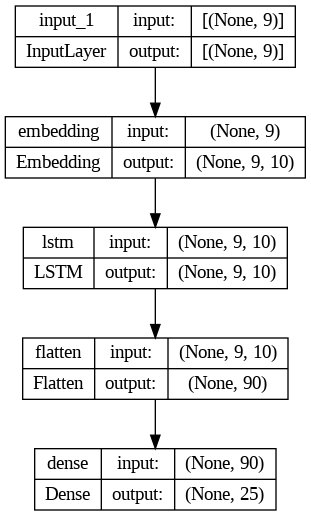

In [26]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 embedding (Embedding)       (None, 9, 10)             2380      
                                                                 
 lstm (LSTM)                 (None, 9, 10)             840       
                                                                 
 flatten (Flatten)           (None, 90)                0         
                                                                 
 dense (Dense)               (None, 25)                2275      
                                                                 
Total params: 5,495
Trainable params: 5,495
Non-trainable params: 0
_________________________________________________________________


In [28]:
train = model.fit(x_train, y_train, epochs=500)

Epoch 1/500
7/7 [==============================] - 2s 6ms/step - loss: 3.2202 - accuracy: 0.0300 
Epoch 2/500
7/7 [==============================] - 0s 6ms/step - loss: 3.2142 - accuracy: 0.0700
Epoch 3/500
7/7 [==============================] - 0s 5ms/step - loss: 3.2096 - accuracy: 0.1150
Epoch 4/500
7/7 [==============================] - 0s 6ms/step - loss: 3.2046 - accuracy: 0.1950
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 3.1985 - accuracy: 0.1900
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 3.1914 - accuracy: 0.2000
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 3.1800 - accuracy: 0.2050
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 3.1664 - accuracy: 0.1750
Epoch 9/500
7/7 [==============================] - 0s 6ms/step - loss: 3.1444 - accuracy: 0.1500
Epoch 10/500
7/7 [==============================] - 0s 6ms/step - loss: 3.1147 - accuracy: 0.1200
Epoch 11/500
7/7 [==========

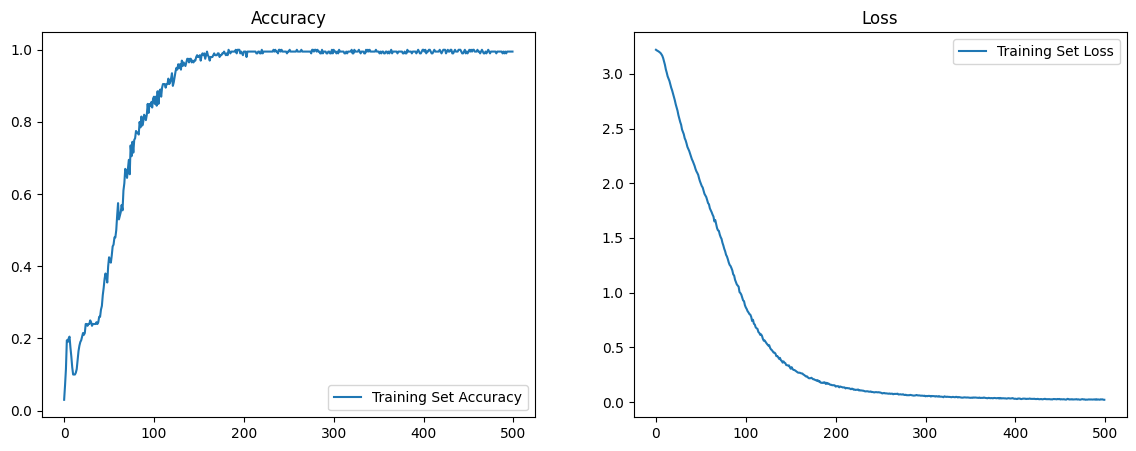

In [29]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [31]:
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')

  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  output = model.predict(prediction_input)
  output = output.argmax()


  response_tag = le.inverse_transform([output])[0]

  print("🤖 BioBot : ", random.choice(responses[response_tag]))

  # Tambahkan respon 'goodbye' agar bot bisa berhenti melakukan percakapan
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : Halo
1/1 [==============================] - 0s 15ms/step
🤖 BioBot :  Hi, BioBot disini, kamu butuh obat atau klaim poin ?
👨‍🦰 Kamu : obat
1/1 [==============================] - 0s 16ms/step
🤖 BioBot :  Kamu lagi sakit apa ?
👨‍🦰 Kamu : Kepala pusing
1/1 [==============================] - 0s 14ms/step
🤖 BioBot :  Gejala ini mengindikasikan infeksi saluran napas atas. Minumlah cairan hangat dan istirahat. Anda bisa menggunakan obat batuk dan pereda nyeri sesuai petunjuk.
👨‍🦰 Kamu : oke
1/1 [==============================] - 0s 16ms/step
🤖 BioBot :  Baiklah sampai jumpa!
👨‍🦰 Kamu : bye
1/1 [==============================] - 0s 15ms/step
🤖 BioBot :  Semoga Lekas Sembuh !
